In [63]:
from jax.numpy import array, transpose
from jax.lax import sort 
from csv import reader

Read the `.csv` using `astropy`, which has trivial sort methods.

In [83]:
with open("Annual_datasets.csv") as intcal20, open("template.csv") as template:
    intcal20 = array([list(map(float, row)) for row in list(reader(intcal20))[1:]]) 
    intcal20 = sort(intcal20, dimension=0, num_keys=1) 
    intcal20 = transpose(intcal20)[:3]
    
    template = array([list(map(float, row)) for row in list(reader(template))[1:]])

In [72]:
from plotnine import ggplot, aes, geom_point, theme_bw

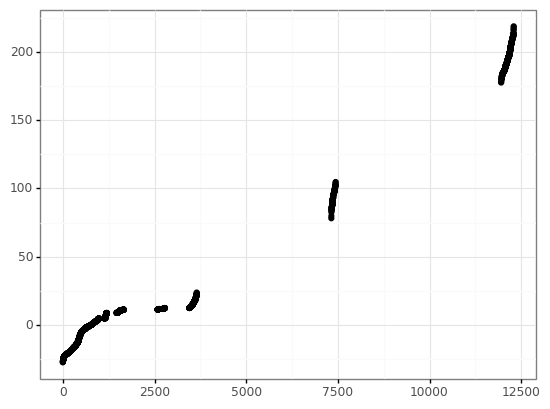

<ggplot: (8747502536078)>

In [84]:
(ggplot(aes(x=intcal20[0], y=intcal20[1]))
    + geom_point()
    + theme_bw()
)

In [2]:
from pandas import read_csv

Import with `pandas` and run with `JAX`. Measured before present (1950). We want to go along by `paper_reference` with a shorter template `30yrs`. The suess effect means that we don't want to include data from 1750ish forward.

In [30]:
intcal20 = read_csv("Annual_datasets.csv")

In [32]:
lengths = [[paper_ref, len(intcal20[intcal20["paper_ref"] == paper_ref])]
    for paper_ref in intcal20["paper_ref"].unique()]
lengths.sort(key = lambda x: x[1])

In [37]:
intcal20 = intcal20[intcal20["paper_ref"] == lengths[-1][0]]

Pick a 100 year block and test the code. So I could fill in the 25 years before and 25 years after with the Intcal20 interpolated curve. Take all of Intcal20 and place the actual data into the interpolated data. This would require rescaling the data with a linear curve or something along those lines. Only test the injection recovery at te real years. 

Linear combination of the basis vectors provided by the template, linear trend and constant.
$Ax = b$ simple linear regression with a 50 by 3 design matrix that is dotted with a 3 long position vector to produce the predicted d14c. The first row is just the template. The second is just rows and the final is just the year.

Resample the data with gaussian noise of the same magnitude as the error bars. Plot the amplitdues as a histogram. Calculate the chi squared statsitic and then do just trend and mean and calculate the difference in chi squared statistic. I choose the significance threshold of the resulting distribution.This gives the false positive rate.

Then you inject a number of small events and see if they are detected based on the thresholds you decided.